### Seminar 6: Atomic structure encoding

Goals/Agenda
- Features importance study

- Forward feature selection
- Matminer for crystal structure featurization
- Datasets size vs. model performance
- Including geometrical features
- Writing featurizers



### Part 1: Feature importance

In [137]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


In [16]:
data = pd.read_csv('data/eg_double_perovskites.csv')
data = data[data.Insulator == 1]

In [17]:
data = data[data.Insulator == 1]

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1577 entries, 12 to 5145
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   functional group  1577 non-null   object 
 1   A                 1577 non-null   object 
 2   A_OS              1577 non-null   int64  
 3   A'                1577 non-null   object 
 4   A'_OS             1577 non-null   int64  
 5   A_HOMO-           1577 non-null   float64
 6   A_HOMO+           1577 non-null   float64
 7   A_IE-             1577 non-null   float64
 8   A_IE+             1577 non-null   float64
 9   A_LUMO-           1577 non-null   float64
 10  A_LUMO+           1577 non-null   float64
 11  A_X-              1577 non-null   float64
 12  A_X+              1577 non-null   float64
 13  A_Z_radii-        1577 non-null   float64
 14  A_Z_radii+        1577 non-null   float64
 15  A_e_affin-        1577 non-null   float64
 16  A_e_affin+        1577 non-null   float64

In [19]:
data = data.drop(['functional group', 'A', "A'", "B'", "Bi", 'Insulator'], axis = 1)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1577 entries, 12 to 5145
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   A_OS          1577 non-null   int64  
 1   A'_OS         1577 non-null   int64  
 2   A_HOMO-       1577 non-null   float64
 3   A_HOMO+       1577 non-null   float64
 4   A_IE-         1577 non-null   float64
 5   A_IE+         1577 non-null   float64
 6   A_LUMO-       1577 non-null   float64
 7   A_LUMO+       1577 non-null   float64
 8   A_X-          1577 non-null   float64
 9   A_X+          1577 non-null   float64
 10  A_Z_radii-    1577 non-null   float64
 11  A_Z_radii+    1577 non-null   float64
 12  A_e_affin-    1577 non-null   float64
 13  A_e_affin+    1577 non-null   float64
 14  B_OS          1577 non-null   int64  
 15  B'_OS         1577 non-null   float64
 16  B_HOMO-       1577 non-null   float64
 17  B_HOMO+       1577 non-null   float64
 18  B_IE-         1577 non-null

Let's analyze the correlation between the features and the target property (PBE band gap)

In [58]:
corr_data = data.corr()['PBE band gap'].sort_values()[:-1] # -1 is to drop target value

<BarContainer object of 33 artists>

/Users/artemdembitskiy/opt/anaconda3/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 119861 (\N{MATHEMATICAL ITALIC CAPITAL B}) missing from current font.
  func(*args, **kwargs)
/Users/artemdembitskiy/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 119861 (\N{MATHEMATICAL ITALIC CAPITAL B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


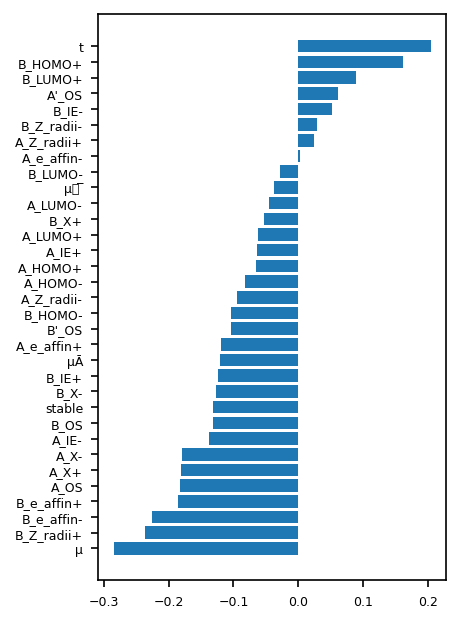

In [59]:
plt.rcParams.update({'font.size': 6})
plt.figure(dpi = 150, figsize = (3,5))
plt.barh(corr_data.index, corr_data.values)

I would expect the features with the highest correlation would be the most important. Will see.

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [228]:
# split data into train and test subsamples
X = data.drop(['PBE band gap'], axis = 1)
y = data['PBE band gap']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True)

#### Model selection with grid search

Grid search is the method of optimizng hyperparameters of the model. We iteratively fit model for each set of possible hyperparameters.

In [273]:
from sklearn.model_selection import GridSearchCV


rf = RandomForestRegressor(n_estimators=50, random_state=1)
param_grid = [
  {
    'n_estimators': [20, 50, 100],
    'max_depth': [4, 6, 10, 12, 14, 16],
    'max_features': [2, 4, 8],
   },
]
gs = GridSearchCV(rf, param_grid, n_jobs=4, cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)
print(gs.score(X_test, y_test))

0.7752258714838314
{'max_depth': 16, 'max_features': 8, 'n_estimators': 100}
0.802465135792982


In [274]:
model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=14, max_features = 8)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=14, max_features=8, random_state=42)

In [275]:
fi = model.feature_importances_
fea_labels = model.feature_names_in_

importances = pd.DataFrame()

importances['fi'] = fi
importances['fea_label'] = fea_labels


In [276]:
corr_data = pd.DataFrame(corr_data)
corr_data['fea_label'] = corr_data.index


In [277]:

df = corr_data.merge(importances)

<BarContainer object of 33 artists>

/Users/artemdembitskiy/opt/anaconda3/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 119861 (\N{MATHEMATICAL ITALIC CAPITAL B}) missing from current font.
  func(*args, **kwargs)
/Users/artemdembitskiy/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 119861 (\N{MATHEMATICAL ITALIC CAPITAL B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


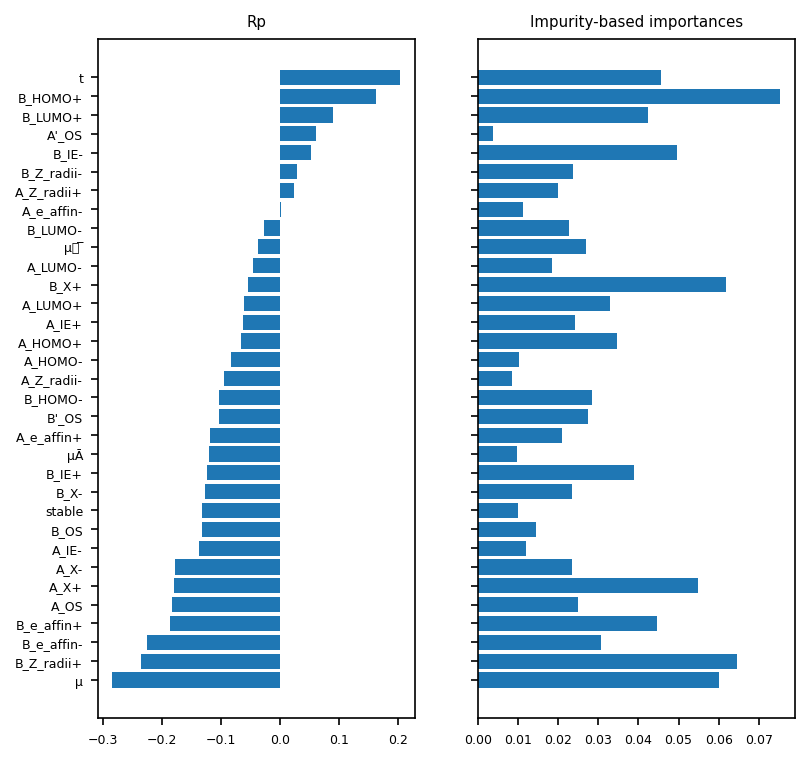

In [278]:
plt.rcParams.update({'font.size': 6})
fig, (ax1, ax2) = plt.subplots(dpi = 150, figsize = (6, 6), ncols = 2, sharey= True)
ax1.barh(df.fea_label, df['PBE band gap'])
ax1.set_title('Rp')

ax2.set_title('Impurity-based importances')
ax2.barh(df.fea_label, df.fi)

In [279]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model, X_train, y_train,
                           n_repeats=5,
                           random_state=0)

In [280]:
r.importances_mean
X_train.columns

pi = pd.DataFrame()

pi['fea_label'] = X_train.columns
pi['fi_pi'] = r.importances_mean

df_ = df.merge(pi)

In [281]:
df_

,PBE band gap,fea_label,fi,fi_pi
0,-0.284750,μ,0.060178,0.079010
1,-0.236494,B_Z_radii+,0.064669,0.109018
2,-0.224959,B_e_affin-,0.030650,0.026432
3,-0.185901,B_e_affin+,0.044599,0.051350
4,-0.182799,A_OS,0.025015,0.056173
5,-0.180455,A_X+,0.054823,0.107013
6,-0.178673,A_X-,0.023487,0.028415
7,-0.137359,A_IE-,0.012000,0.010896
8,-0.132137,B_OS,0.014346,0.009421
9,-0.132003,stable,0.010008,0.015529


Text(0.5, 1.0, 'Permutation importances')

/Users/artemdembitskiy/opt/anaconda3/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 119861 (\N{MATHEMATICAL ITALIC CAPITAL B}) missing from current font.
  func(*args, **kwargs)
/Users/artemdembitskiy/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 119861 (\N{MATHEMATICAL ITALIC CAPITAL B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


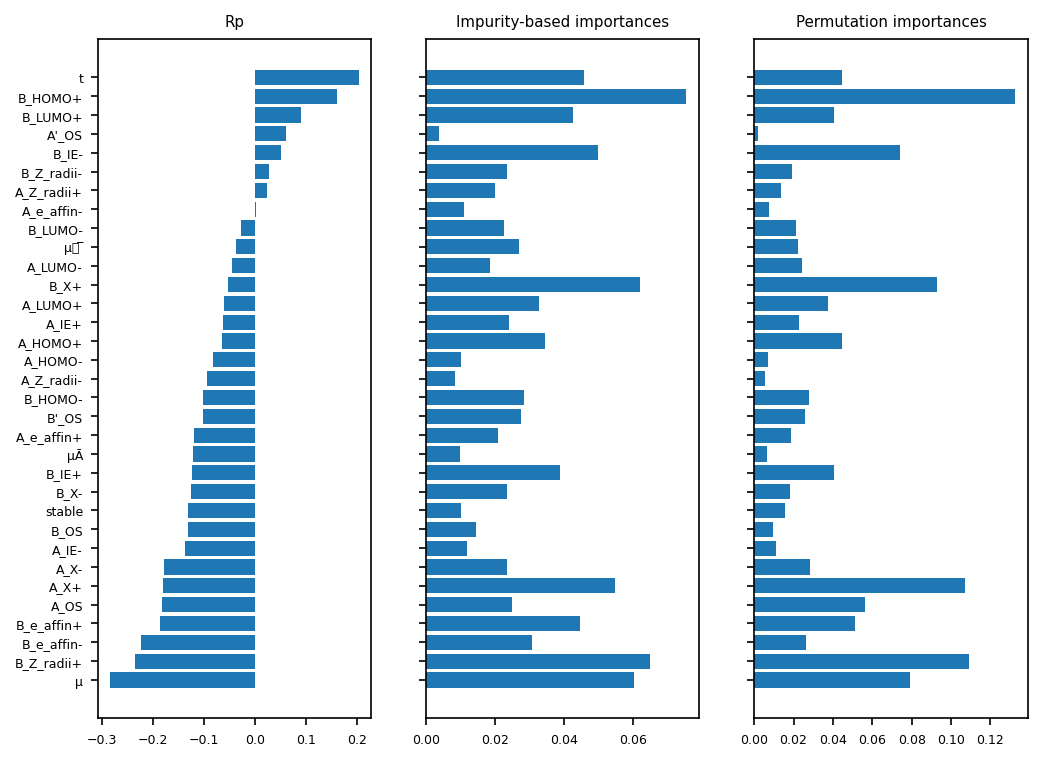

In [282]:
plt.rcParams.update({'font.size': 6})
fig, (ax1, ax2, ax3) = plt.subplots(dpi = 150, figsize = (8, 6), ncols = 3, sharey= True)

ax1.barh(df_.fea_label, df_['PBE band gap'])
ax1.set_title('Rp')

ax2.barh(df_.fea_label, df_.fi)
ax2.set_title('Impurity-based importances')


ax3.barh(df_.fea_label, df_.fi_pi)
ax3.set_title('Permutation importances')


### Task 1: Forward feature selection

- Implement a forward feature selection algorithm

- Select top10 features using RF model

- Plot  MSE(Eg prediction) vs # of seleted features

In [283]:
def MSE(pred, true):
    return np.square(pred - true).mean()

Note: It should be in a cross-validation loop. But for simplicity, we use a single data split of a train subsample into train and val parts.


In [285]:
features = X_train.columns

best_features = []
mse_history = []

X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size = 0.2, shuffle=True, random_state=42)


for k in tqdm(range(15)):
    best_score = np.inf
    current_best_feature = None
    for feature in features:
        if feature in best_features:
            continue
        current_features = best_features.copy()
        current_features.append(feature)

        X_step = X_train_[current_features].values
        if len(current_features) == 1:
            X_step = X_step.reshape(-1, 1)
        model = RandomForestRegressor(n_estimators=20) # for simplicity we use smaller number of estimators
        model.fit(X_step, y_train_)
        pred = model.predict(X_val[current_features].values)
        score = MSE(pred, y_val) 
        if score < best_score:
            best_score = score
            current_best_feature = feature
    best_features.append(current_best_feature)
    mse_history.append(best_score)

100%|██████████| 15/15 [00:22<00:00,  1.53s/it]


Do these features correspond to the most important descriptors?

In [238]:
best_features[:8]

['B_LUMO+', 'B_X-', 'A_X+', 'A_LUMO+', 'μ', 'B_X+', 'B_Z_radii+', 'B_OS']

Text(0.5, 0, '# features')

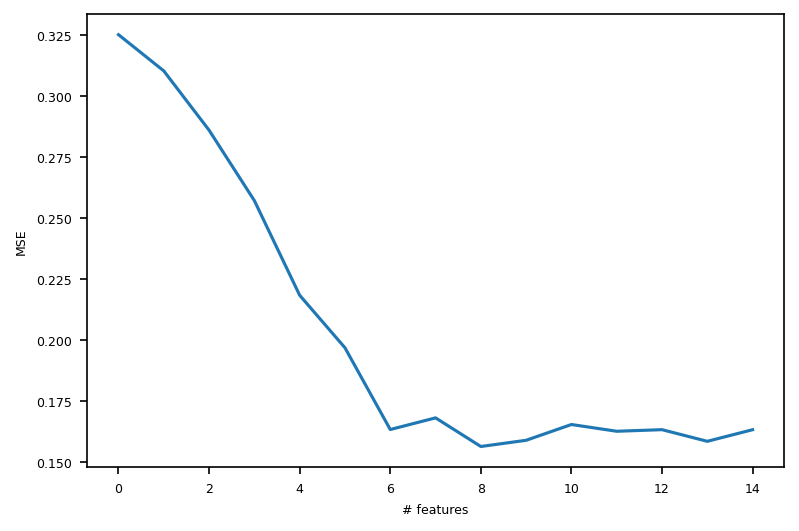

In [231]:
plt.figure(dpi = 150)
plt.plot(mse_history)
plt.ylabel('MSE')
plt.xlabel('# features')

### Part 2: Matminer

The [matminer package](https://hackingmaterials.lbl.gov/matminer/index.html) is developed for converting atomic structure into features.

Attribution: Parts of this notebook are adopted from the "Review of matminer features" by Enze Chen and Mark Asta (University of California, Berkeley)

source: https://colab.research.google.com/github/enze-chen/mi-book/blob/master/week_2/08/matminer_features_blank.ipynb#scrollTo=c7242cf7


#### Compositional features



We will use elemental features (Magpie) (see the [original paper](https://www.nature.com/articles/npjcompumats201628))

We take the property (such as `AtomicWeight` or `Electronegativity`) of all of the constituent elements and calculate its descriptive statistics - average, maximum, minimum, etc. 



In [183]:
from pymatgen.core import Composition
from matminer.featurizers.composition import ElementProperty

features = [
'Number',
'MendeleevNumber',
'AtomicWeight',
'MeltingT', 
'Column', 
'Row', 
'CovalentRadius', 
'Electronegativity', 
'NsValence', 
'NpValence', 
'NdValence',
'NfValence', 
'NValence', 
'NsUnfilled', 
'NpUnfilled',
'NdUnfilled', 
'NfUnfilled', 
'NUnfilled', 
'GSvolume_pa',
'GSbandgap',
'GSmagmom',
'SpaceGroupNumber'
]

# these are the statistical quantities we can compute
stats = ['mean']   # we can also add 'minimum', 'maximum', 'range', 'avg_dev', 'mode'

featurizer = ElementProperty(data_source='magpie',
                             features=features,
                             stats=stats)



In [184]:
data = pd.read_csv('data/eg_double_perovskites.csv')
data = data[data.Insulator == 1]

def _get_composition(formula):
    return Composition(formula)
    
data['composition'] = data['functional group'].apply(_get_composition)

,functional group,A,A_OS,A',A'_OS,A_HOMO-,A_HOMO+,A_IE-,A_IE+,A_LUMO-,...,B_e_affin-,B_e_affin+,Insulator,PBE band gap,μ,μĀ,μ𝐵 ̅,stable,t,composition
12,AgCsZrTeO6,Ag,3,Cs,1,1.1480,-3.2570,177.65,553.35,0.0035,...,74.55,115.65,1,1.5453,0.60357,0.23214,0.08929,1,0.93074,"(Ag, Cs, Zr, Te, O)"
32,AgNbO3,Ag,1,Ag,1,0.0000,-4.4050,0.00,731.00,0.0000,...,0.00,86.20,1,1.3259,0.45714,0.00000,0.00000,0,1.00173,"(Ag, Nb, O)"
36,AgPbWAlO6,Ag,3,Pb,2,0.4545,-3.9505,7.75,723.25,0.0435,...,17.30,61.30,1,2.0298,0.42679,0.09286,0.04464,1,0.97703,"(Ag, Pb, W, Al, O)"
49,AgTaO3,Ag,1,Ag,1,0.0000,-4.4050,0.00,731.00,0.0000,...,0.00,31.00,1,1.7301,0.45714,0.00000,0.00000,1,1.00173,"(Ag, Ta, O)"
65,AsBO3,As,3,As,3,0.0000,-5.1940,0.00,946.50,0.0000,...,0.00,26.70,1,0.5587,0.19286,0.00000,0.00000,0,1.08395,"(As, B, O)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5100,YScO3,Y,3,Y,3,0.0000,-2.5620,0.00,615.60,0.0000,...,0.00,18.10,1,2.3337,0.53214,0.00000,0.00000,0,0.87358,"(Y, Sc, O)"
5101,YSmO3,Y,3,Y,3,0.0000,-2.5620,0.00,615.60,0.0000,...,0.00,15.63,1,0.9720,0.68429,0.00000,0.00000,0,0.79467,"(Y, Sm, O)"
5113,YTlVGdO6,Y,3,Tl,1,0.0975,-2.4645,13.15,602.45,0.9355,...,18.74,31.96,1,0.8446,0.52786,0.16071,0.14214,1,0.95041,"(Y, Tl, V, Gd, O)"
5126,YYbHfCoO6,Y,3,Yb,2,0.2335,-2.7955,6.10,609.50,0.6660,...,23.40,40.40,1,1.1944,0.47143,0.04643,0.03571,1,0.93194,"(Y, Yb, Hf, Co, O)"


In [186]:
df_features = featurizer.featurize_dataframe(data, col_id='composition')
feature_labels = featurizer.feature_labels()

ElementProperty:   0%|          | 0/1577 [00:00<?, ?it/s]

In [212]:
data_new = df_features.drop(['functional group', 'A', "A'", "B'", "Bi", 'Insulator', 'composition'], axis = 1)

In [246]:
# split data into train and test subsamples
X = data_new.drop(['PBE band gap'], axis = 1)
y = data_new['PBE band gap']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state=42)

In [233]:
model = RandomForestRegressor(n_estimators=400, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=400, random_state=42)

In [234]:
preds = model.predict(X_test)
MSE(preds, y_test)

0.13484815386687032

In [240]:
data = pd.read_csv('data/eg_double_perovskites.csv')
data = data[data.Insulator == 1]
data = data.drop(['functional group', 'A', "A'", "B'", "Bi", 'Insulator'], axis = 1)
X = data.drop(['PBE band gap'], axis = 1)
y = data['PBE band gap']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state=42)

In [241]:
model = RandomForestRegressor(n_estimators=20, random_state=42)
model.fit(X_train[best_features[:8]], y_train)

RandomForestRegressor(n_estimators=20, random_state=42)

In [243]:
preds = model.predict(X_test[best_features[:8]])
MSE(preds, y_test)

0.12798800614659833

The inclusion of gross level elemental features does not increase the score. Let's see if one of the included features is more important than the original one.

In [247]:
features = X_train.columns

best_features = []
mse_history = []

X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size = 0.2, shuffle=True, random_state=42)


for k in tqdm(range(15)):
    best_score = np.inf
    current_best_feature = None
    for feature in features:
        if feature in best_features:
            continue
        current_features = best_features.copy()
        current_features.append(feature)

        X_step = X_train_[current_features].values
        if len(current_features) == 1:
            X_step = X_step.reshape(-1, 1)
        model = RandomForestRegressor(n_estimators=20) 
        model.fit(X_step, y_train_)
        pred = model.predict(X_val[current_features].values)
        score = MSE(pred, y_val) 
        if score < best_score:
            best_score = score
            current_best_feature = feature
    best_features.append(current_best_feature)
    mse_history.append(best_score)

100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


In [249]:
best_features

['B_e_affin+',
 'MagpieData mean Column',
 "A'_OS",
 'MagpieData mean GSbandgap',
 'A_X-',
 'A_X+',
 'B_e_affin-',
 'MagpieData mean NdValence',
 'MagpieData mean NValence',
 'B_IE+',
 'MagpieData mean NfUnfilled',
 'μĀ',
 "B'_OS",
 'stable',
 'MagpieData mean GSmagmom']

Text(0.5, 0, '# features')

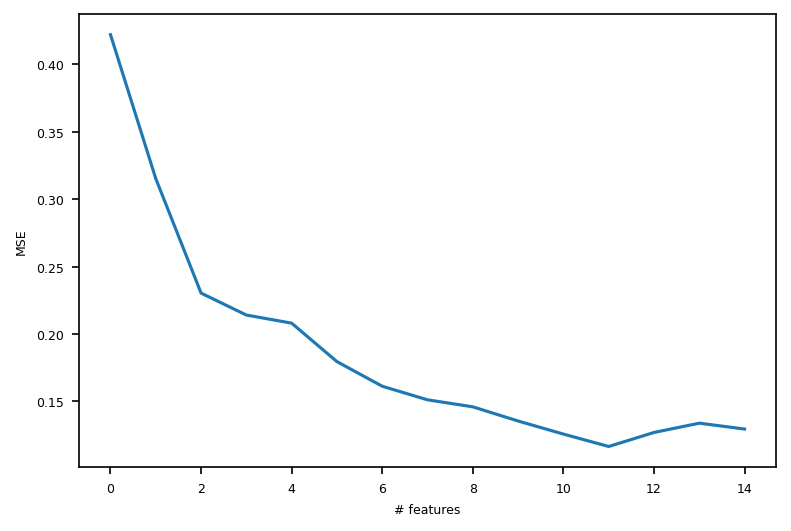

In [250]:
plt.figure(dpi = 150)
plt.plot(mse_history)
plt.ylabel('MSE')
plt.xlabel('# features')

In [253]:
mse_history[:12]

[0.42199494699209716,
 0.31524349676574764,
 0.23035883248157485,
 0.21409697544815764,
 0.20806412439409108,
 0.17954770616821872,
 0.16130255951432387,
 0.1512205699487407,
 0.14602748996161635,
 0.1355080180112045,
 0.12582259020042655,
 0.1166204022098812]

In [255]:
model = RandomForestRegressor(n_estimators=20, random_state=42)
model.fit(X_train[best_features[:12]], y_train)

RandomForestRegressor(n_estimators=20, random_state=42)

In [257]:
preds = model.predict(X_test[best_features[:12]])

In [258]:
MSE(preds, y_test)

0.14694838576700964

#### Some structural features

In [300]:
from matminer.featurizers.structure import DensityFeatures
from pymatgen.core import Structure
st = Structure.from_file('data/LiBr.cif')

featurizer = DensityFeatures()

dict(zip(featurizer.feature_labels(), featurizer.featurize(st)))

{'density': 3.5724738210211786,
 'vpa': 20.183425052734915,
 'packing fraction': 0.47416820462238135}

#### Presets in matminer
Adopted from matminer [examples](https://github.com/hackingmaterials/matminer_examples/blob/main/matminer_examples/machine_learning-nb/voronoi-ward-prb-2017.ipynb)


Here we will try to predict formation energy of crystal structures using both elemental and geometrical descriptors. The geometrical properties are collected using Voronoi partitioning as implemnted in Ward et al..

In [301]:
from matminer.datasets import load_dataset
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers.composition import ElementProperty, Stoichiometry, ValenceOrbital, IonProperty
from matminer.featurizers.structure import (
                                                SiteStatsFingerprint,
                                                StructuralHeterogeneity,
                                                ChemicalOrdering,
                                                StructureComposition,
                                                MaximumPackingEfficiency
                                                )
from matminer.featurizers.conversions import DictToObject
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy import stats
from tqdm import tqdm_notebook as tqdm

In [303]:
# create featurizer
featurizer = MultipleFeaturizer([
    SiteStatsFingerprint.from_preset("CoordinationNumber_ward-prb-2017"),
    StructuralHeterogeneity(),
    ChemicalOrdering(),
    MaximumPackingEfficiency(),
    SiteStatsFingerprint.from_preset("LocalPropertyDifference_ward-prb-2017"),
    StructureComposition(Stoichiometry()),
    StructureComposition(ElementProperty.from_preset("magpie")),
    StructureComposition(ValenceOrbital(props=['frac'])),
    StructureComposition(IonProperty(fast=True))
])

In [304]:
# load data
data = load_dataset("flla")


In [305]:
dto = DictToObject(target_col_id='structure', overwrite_data=True)
data = dto.featurize_dataframe(data, 'structure')

DictToObject:   0%|          | 0/3938 [00:00<?, ?it/s]

In [307]:
data_samll = data.sample(500)

In [308]:
X = featurizer.featurize_many(data_samll['structure'], ignore_errors=True)

MultipleFeaturizer:   0%|          | 0/500 [00:00<?, ?it/s]

In [319]:
X = np.array(X)
y = data_samll['formation_energy_per_atom']

In [317]:
import pandas as pd
failed = np.any(pd.isnull(X), axis=1)
print('Number failed: {}/{}'.format(np.sum(failed), len(failed)))

Number failed: 15/500


### Task 2: Fit the model

- Perform grid search to optimize hyperparameters of your model

- Fit model on training dataset 

- Evaluate feature importances

- Report test scores

In [312]:
from sklearn.kernel_ridge import KernelRidge

model = Pipeline([
    ('imputer', SimpleImputer()), # For the failed structures
    ('imputer', StandardScaler()), 
    ('model', KernelRidge(kernel="rbf"))
])

### Task 3: Your own featurizer

- Collect vanadium phosphates from MP data base

- Write your own featurizer to predict formation_energy_per_atom

- Featurizer should include 
    - geometrical features

    - elemental features

- Featurize collected structures
- Fit your favorite regression model
- Study feature importances



In [291]:
class StructureFeaturizer:

    """Featurizer of pymatgen's crystal structure
    
    Params:
    ------
    st: pymatgen's Structure object

    """

    def __init__(self, st):
        self.st = st


    ### your code ###

    
    def featurize(self):

        """
        This method calculates features of a crystal structure
        stored in self.st
        """

        features = {}

        return features
        